In [12]:
from PIL import Image
# import matplotlib.pyplot as plt
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transf
# from IPython.display import clear_output
import torch.nn as nn
# import torch.nn.functional as F
import torchmetrics
from utils.dataset import CaptchaDataset
from utils.train import train
from utils.model import OCRmodel
from utils.utils import create_char_dicts
from utils.utils import decode_nums

from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# Note: solution is based on 
# https://www.kaggle.com/code/kowalskyyy999/captcha-recognition-crnn-ctcloss-using-pytorch
# and modified architecture from here:
# https://arxiv.org/pdf/1507.05717.pdf

In [3]:
PATH_TO_DATA = "samples/"
device = "cuda:0" if torch.cuda.is_available() else "cpu"
RANDOM_STATE = 42

# Split train test data and create char <-> num mapper

In [4]:
# create global paths
data = glob.glob(os.path.join(PATH_TO_DATA, '*.png'))
# split data to train and test
train_imgs, test_imgs = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
# create mapping for char and class label (and vice versa)
char_dict, inv_char_dict = create_char_dicts(PATH_TO_DATA)

# Create dataset

In [5]:
transforms = transf.Compose([transf.ToTensor()])
train_dataset = CaptchaDataset(train_imgs, char_dict=char_dict, 
                               inv_char_dict=inv_char_dict, transform=transforms)
test_dataset = CaptchaDataset(test_imgs, char_dict=char_dict, 
                              inv_char_dict=inv_char_dict, transform=transforms)

# Create Dataloaders

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train model

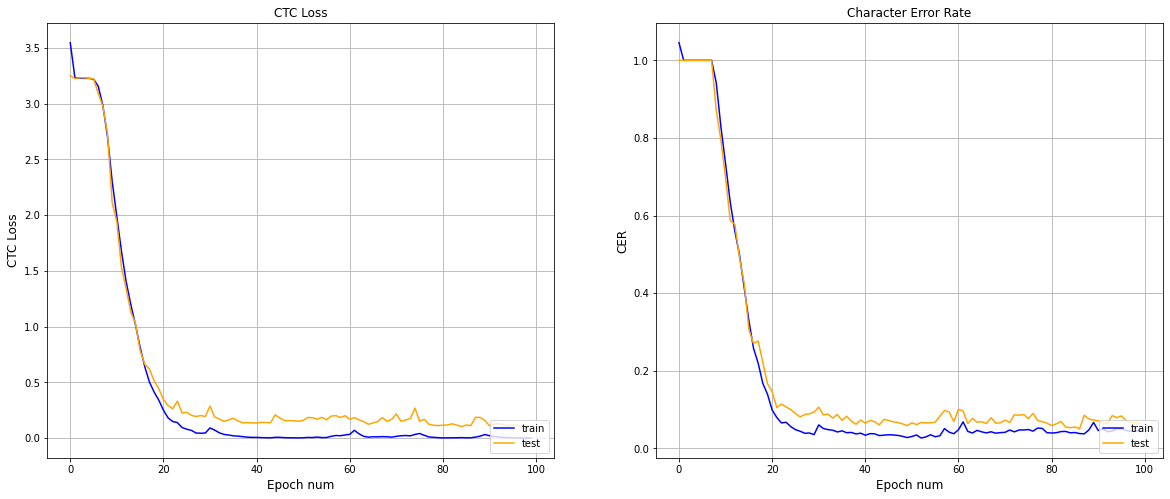

Training CER: 0.04399038851261139   Test CER: 0.06517857313156128


In [7]:
model = OCRmodel(in_channels=1, 
                 cnn_out_dim=1024,
                 seq_dim=128,
                 rnn_hidden_dim=2 * 128,
                 num_classes=len(char_dict.keys())).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_num = 100
criterion = nn.CTCLoss()
metric = torchmetrics.CharErrorRate()
train(model, 
      optim, 
      criterion, 
      metric, 
      epoch_num, 
      train_loader, 
      test_loader, 
      inv_char_dict=inv_char_dict, 
      device=device)

# Load final model and assess the results

In [13]:
final_model = OCRmodel(in_channels=1, 
                       cnn_out_dim=1024,
                       seq_dim=128,
                       rnn_hidden_dim=2 * 128,
                       num_classes=len(char_dict.keys())).to(device)
final_model.load_state_dict(torch.load("./ocr_model.pth"))

<All keys matched successfully>

In [14]:
test_iter = iter(test_loader)

In [21]:
test_data, test_labels = next(test_iter)
out, input_lengths, target_lengths = final_model(test_data.to(device))
out = out.permute(1, 0, 2)
out = out.log_softmax(2)
out = out.argmax(-1)
decoded_out = decode_nums(out, inv_char_dict)
decoded_labels = decode_nums(test_labels, inv_char_dict)

In [22]:
decoded_out[10:15]

['44fyb', 'f22bn', 'pcede', 'mw5p2', 'dbex3']

In [23]:
decoded_labels[10:15]

['44fyb', 'f22bn', 'pcede', 'mw5p2', 'dbex3']

# TODO
* add conclusion according to train
* add code for examples estimation 
* add conclusion according to results
* add readme